In [11]:
!pip install kaggle

In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedcurious","key":"e2c882d9356b05f440f4a9433ebdf108"}'}

In [15]:
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d shreyapmaher/fruits-dataset-images

Dataset URL: https://www.kaggle.com/datasets/shreyapmaher/fruits-dataset-images
License(s): other
 99% 202M/205M [00:09<00:00, 24.8MB/s]
100% 205M/205M [00:09<00:00, 21.9MB/s]


In [18]:
!unzip fruits-dataset-images.zip -d fruits_dataset

Archive:  fruits-dataset-images.zip
  inflating: fruits_dataset/images/apple fruit/Image_1.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_10.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_11.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_12.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_13.png  
  inflating: fruits_dataset/images/apple fruit/Image_14.png  
  inflating: fruits_dataset/images/apple fruit/Image_15.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_16.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_17.jpeg  
  inflating: fruits_dataset/images/apple fruit/Image_18.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_19.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_2.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_20.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_21.jpg  
  inflating: fruits_dataset/images/apple fruit/Image_22.jpg  
  inflating: fruits_dataset/images/

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [20]:
# Define the main dataset path (based on your folder structure)
main_dataset_dir = '/content/fruits_dataset/images'

# Create subdirectories for train, validation, and test sets
base_dir = '/content/fruits_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create directories for each fruit type in each split
fruit_types = os.listdir(main_dataset_dir)
for fruit in fruit_types:
    os.makedirs(os.path.join(train_dir, fruit), exist_ok=True)
    os.makedirs(os.path.join(val_dir, fruit), exist_ok=True)
    os.makedirs(os.path.join(test_dir, fruit), exist_ok=True)

In [22]:
import random
import shutil

def split_data(source_dir, train_dir, val_dir, test_dir, split_size):
    for fruit in fruit_types:
        path = os.path.join(source_dir, fruit)
        images = os.listdir(path)
        random.shuffle(images)

        train_size = int(len(images) * split_size[0])
        val_size = int(len(images) * split_size[1])

        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]

        # Move files
        for img in train_images:
            shutil.copy(os.path.join(path, img), os.path.join(train_dir, fruit, img))
        for img in val_images:
            shutil.copy(os.path.join(path, img), os.path.join(val_dir, fruit, img))
        for img in test_images:
            shutil.copy(os.path.join(path, img), os.path.join(test_dir, fruit, img))

# Split ratio: 70% train, 20% validation, 10% test
split_data(main_dataset_dir, train_dir, val_dir, test_dir, split_size=(0.7, 0.2, 0.1))


In [23]:
# Data augmentation and normalization for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only normalization for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 252 images belonging to 9 classes.
Found 71 images belonging to 9 classes.
Found 36 images belonging to 9 classes.


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation='softmax')  # 9 classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,  # Adjust epochs as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1002 - loss: 2.2352 - val_accuracy: 0.1250 - val_loss: 2.1509
Epoch 2/20
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2812 - loss: 2.1038

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.2812 - loss: 2.1038 - val_accuracy: 0.0000e+00 - val_loss: 2.2309
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 509ms/step - accuracy: 0.1765 - loss: 2.0852 - val_accuracy: 0.2188 - val_loss: 1.9650
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.2812 - loss: 1.9933 - val_accuracy: 0.7143 - val_loss: 1.6392
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - accuracy: 0.3028 - loss: 1.8729 - val_accuracy: 0.2969 - val_loss: 1.8187
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - accuracy: 0.2143 - loss: 2.0702 - val_accuracy: 0.2857 - val_loss: 1.6241
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 546ms/step - accuracy: 0.2765 - loss: 1.7396 - val_accuracy: 0.3438 - val_loss: 1.5322
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 331ms/step - accuracy: 0.2500 - loss: 1.7579 - val_accuracy: 0.4286 - val_loss: 1.8834
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 436ms/step - accuracy: 0.3076 - loss: 1.6746 - val_accuracy: 0.4688 - val_loss: 1.

In [27]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step - accuracy: 0.4375 - loss: 1.6753
Test Accuracy: 43.75%


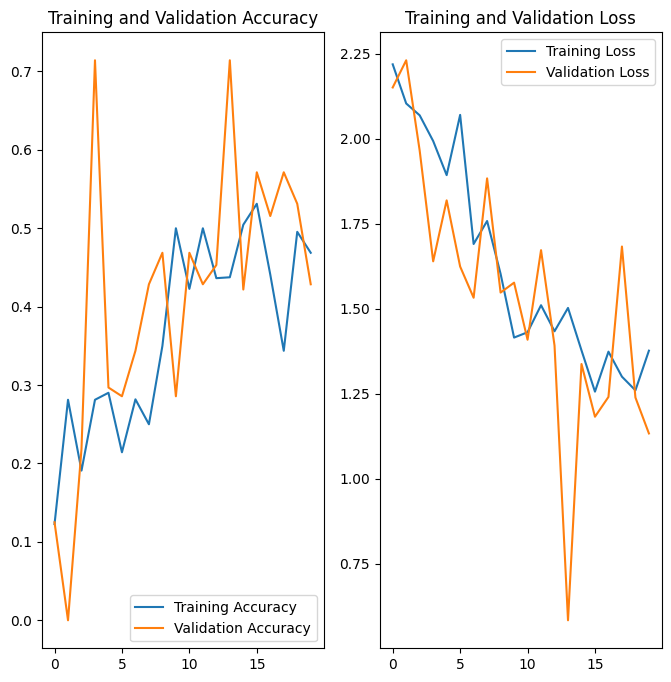

In [28]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()